# Sparkify - Model Training & Evaluation

This notebooks uses the train/test sample data generated in `1_eda_cleaning_feature_engineering_sample.ipynb` to set-up and test the modeling pipelines. Once ready, I'll be leverage Azure Databricks to run the pipelines at scale. We'll compare two modeling techniques:
1. Penalized Logistic Regression
2. Gradient-Boosted Trees 

In [1]:
# import libraries
from pyspark.sql import SparkSession
import sys
sys.path.append("../src")
from sparkifychurn import trainModel, evaluateModel
from pyspark import SparkConf
import pyspark.sql.functions as F
import pandas as pd
pd.set_option("max.columns", None)
pd.set_option("max.rows", None)
import seaborn as sns

from pyspark.ml.tuning import CrossValidatorModel

## Set-up Spark
Since the sample data is quite small, we can use the laptop's CPU in a pyspark local kernel to create a Spark Session. 

In [2]:
spark = SparkSession\
        .builder\
        .appName("Sparkify")\
        .config("spark.ui.showConsoleProgress", False)\
        .getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/02/20 20:39:51 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
spark

## Load Data 

In [4]:
train = spark.read.parquet("../data/train_data_sample")
test = spark.read.parquet("../data/test_data_sample")

It's helpful to coalesce these small dataframes down to a single partition to boost performance. They are too small to do distributed computing.

In [5]:
train = train.coalesce(1).cache()
test = test.coalesce(1).cache()

train.limit(5).toPandas()

22/02/20 20:40:01 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


,userId,gender,count_items,sum_length,paid,session_count,submit_downgrade_count,thumbs_down_count,home_count,downgrade_count,advert_count,save_settings_count,churn,about_count,settings_count,add_playlist_count,add_friend_count,next_song_count,thumbs_up_count,help_count,upgrade_count,error_count,submit_upgrade,non_song_interaction_count,PUT_200_count,GET_200_count,PUT_307_count,tenure_days,thumbs_up_pct,avg_items_session,avg_songs_session,sum_session_length_hours,avg_session_length_hours,interaction_rate,submit_downgrade_rate,thumbs_down_rate,home_rate,downgrade_rate,advert_rate,save_settings_rate,about_rate,settings_rate,add_playlist_rate,add_friend_rate,next_song_rate,thumbs_up_rate,help_rate,upgrade_rate,error_rate,non_song_interaction_rate
0,135,F,6,1596.44461,0,1,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,6,0,0,0.015590,0.000000,6.000000,6.000000,0.374167,0.374167,16.035635,0.0,0.000000,0.000000,0.00000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,16.035635,0.000000,0.00000,0.000000,0.000000,0.000000
1,156,M,6,691.66884,0,1,0,0,1,0,1,0,0,0,1,0,0,3,0,0,0,0,0,3,3,3,0,0.004861,0.000000,6.000000,3.000000,0.116667,0.116667,51.428571,0.0,0.000000,8.571429,0.00000,8.571429,0.00000,0.00000,8.571429,0.000000,0.000000,25.714286,0.000000,0.00000,0.000000,0.000000,25.714286
2,44,F,512,106365.08874,1,3,0,2,15,1,0,1,0,3,4,10,8,429,25,6,1,0,1,83,439,30,43,26.581030,0.925926,170.666667,143.000000,29.316944,9.772315,17.464303,0.0,0.068220,0.511650,0.03411,0.000000,0.03411,0.10233,0.136440,0.341100,0.272880,14.633176,0.852749,0.20466,0.034110,0.000000,2.831127
3,137,M,209,38385.87631,1,3,0,1,12,0,10,0,0,0,1,4,8,154,8,1,4,0,1,55,158,28,23,54.318079,0.888889,69.666667,51.333333,10.563056,3.521019,19.785942,0.0,0.094670,1.136035,0.00000,0.946696,0.00000,0.00000,0.094670,0.378678,0.757357,14.579115,0.757357,0.09467,0.378678,0.000000,5.206827
4,72,F,117,19961.03902,0,1,0,1,5,0,10,0,0,0,0,3,3,85,6,0,2,1,0,32,88,17,11,0.232164,0.857143,117.000000,85.000000,5.571944,5.571944,20.998056,0.0,0.179471,0.897353,0.00000,1.794706,0.00000,0.00000,0.000000,0.538412,0.538412,15.254998,1.076823,0.00000,0.358941,0.179471,5.743058


# Modeling

In [6]:
binary_features = ["paid", "submit_upgrade"]
cat_feature = "gender"
target_feature = "churn"
features_to_scale = list(set(train.columns) - set(["userId", *binary_features, cat_feature, target_feature]))

### Train Logistic Regression Pipeline 

In [7]:
lr_cv_model = trainModel.train_lr_model(num_folds = 5, 
                                        train = train, 
                                        features_to_scale = features_to_scale,
                                        binary_features = binary_features)

22/02/20 20:40:10 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/02/20 20:40:10 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


In [8]:
lr_cv_model.write().overwrite().save("../models/spark_lr_model_sample")

In [9]:
lr_cv_model = CrossValidatorModel.load("../models/spark_lr_model_sample")

Logistic_Regression - Train Set AUROC: 0.934
Logistic_Regression - Test Set AUROC: 0.768


Logistic_Regression - Train Average Precision: 0.811
Logistic_Regression - Test Average Precision: 0.452


Logistic_Regression - Train No Skill Precision: 0.24
Logistic_Regression - Test No Skill Precision: 0.207

 ****Classification Report on Train Data***
              precision    recall  f1-score   support

           0       0.89      0.95      0.92       127
           1       0.81      0.62      0.70        40

    accuracy                           0.87       167
   macro avg       0.85      0.79      0.81       167
weighted avg       0.87      0.87      0.87       167


 ****Classification Report on Test Data***
              precision    recall  f1-score   support

           0       0.87      0.89      0.88        46
           1       0.55      0.50      0.52        12

    accuracy                           0.81        58
   macro avg       0.71      0.70      0.70        58
weighted

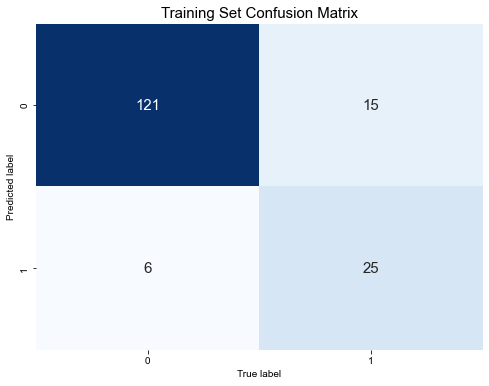

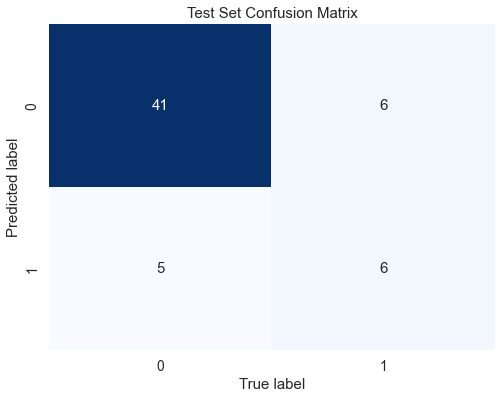

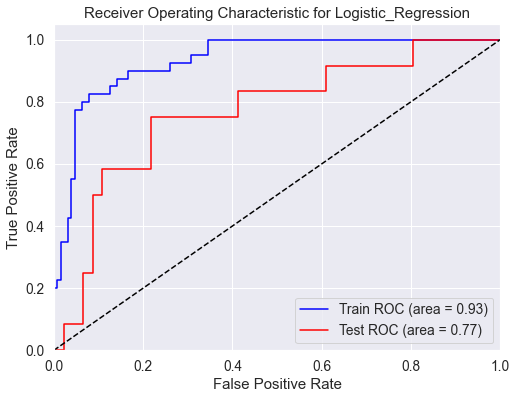

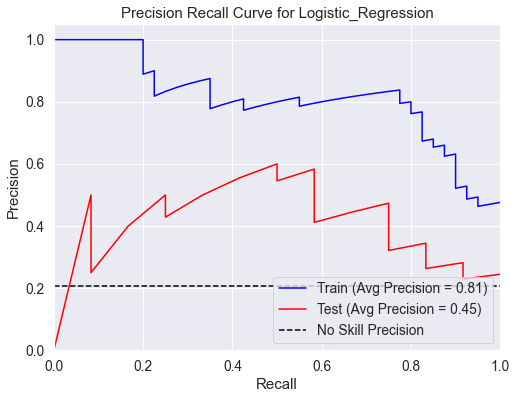

In [10]:
evaluateModel.evaluate_model(model = lr_cv_model,
                             model_type = "pyspark",
                             model_name = "Logistic_Regression",
                             output_path = "../output/pyspark/sample",
                             train = train,
                             test = test)

In [11]:
# It's possible to update the threshold by setting it in the correct pipeline stage: 

#lr_cv_model.bestModel.stages[5].setThreshold(0.4519)
#test_results= lr_cv_model.transform(test)
#lr_cv_model.bestModel.stages[5].getThreshold()

### Train GBT Classifier Pipeline

In [12]:
gbt_cv_model = trainModel.train_gbt_model(num_folds = 5, 
                                          train = train, 
                                          features_to_scale = features_to_scale, 
                                          binary_features = binary_features)

22/02/20 20:47:15 WARN DAGScheduler: Broadcasting large task binary with size 1001.1 KiB
22/02/20 20:47:15 WARN DAGScheduler: Broadcasting large task binary with size 1001.6 KiB
22/02/20 20:47:15 WARN DAGScheduler: Broadcasting large task binary with size 1002.3 KiB
22/02/20 20:47:15 WARN DAGScheduler: Broadcasting large task binary with size 1003.3 KiB
22/02/20 20:47:16 WARN DAGScheduler: Broadcasting large task binary with size 1005.5 KiB
22/02/20 20:47:16 WARN DAGScheduler: Broadcasting large task binary with size 1007.7 KiB
22/02/20 20:47:16 WARN DAGScheduler: Broadcasting large task binary with size 1008.1 KiB
22/02/20 20:47:16 WARN DAGScheduler: Broadcasting large task binary with size 1008.8 KiB
22/02/20 20:47:16 WARN DAGScheduler: Broadcasting large task binary with size 1009.8 KiB
22/02/20 20:47:16 WARN DAGScheduler: Broadcasting large task binary with size 1012.0 KiB
22/02/20 20:47:16 WARN DAGScheduler: Broadcasting large task binary with size 1014.2 KiB
22/02/20 20:47:17 WAR

22/02/20 20:47:26 WARN DAGScheduler: Broadcasting large task binary with size 1120.1 KiB
22/02/20 20:47:26 WARN DAGScheduler: Broadcasting large task binary with size 1122.3 KiB
22/02/20 20:47:26 WARN DAGScheduler: Broadcasting large task binary with size 1124.5 KiB
22/02/20 20:47:26 WARN DAGScheduler: Broadcasting large task binary with size 1125.0 KiB
22/02/20 20:47:26 WARN DAGScheduler: Broadcasting large task binary with size 1125.7 KiB
22/02/20 20:47:26 WARN DAGScheduler: Broadcasting large task binary with size 1126.7 KiB
22/02/20 20:47:27 WARN DAGScheduler: Broadcasting large task binary with size 1128.9 KiB
22/02/20 20:47:27 WARN DAGScheduler: Broadcasting large task binary with size 1131.1 KiB
22/02/20 20:47:27 WARN DAGScheduler: Broadcasting large task binary with size 1131.5 KiB
22/02/20 20:47:27 WARN DAGScheduler: Broadcasting large task binary with size 1132.3 KiB
22/02/20 20:47:27 WARN DAGScheduler: Broadcasting large task binary with size 1133.2 KiB
22/02/20 20:47:27 WAR

22/02/20 20:47:38 WARN DAGScheduler: Broadcasting large task binary with size 1241.1 KiB
22/02/20 20:47:38 WARN DAGScheduler: Broadcasting large task binary with size 1241.9 KiB
22/02/20 20:47:38 WARN DAGScheduler: Broadcasting large task binary with size 1242.9 KiB
22/02/20 20:47:38 WARN DAGScheduler: Broadcasting large task binary with size 1245.0 KiB
22/02/20 20:47:38 WARN DAGScheduler: Broadcasting large task binary with size 1247.2 KiB
22/02/20 20:47:39 WARN DAGScheduler: Broadcasting large task binary with size 1247.7 KiB
22/02/20 20:47:39 WARN DAGScheduler: Broadcasting large task binary with size 1248.4 KiB
22/02/20 20:47:39 WARN DAGScheduler: Broadcasting large task binary with size 1249.4 KiB
22/02/20 20:47:39 WARN DAGScheduler: Broadcasting large task binary with size 1251.6 KiB
22/02/20 20:47:39 WARN DAGScheduler: Broadcasting large task binary with size 1253.7 KiB
22/02/20 20:47:39 WARN DAGScheduler: Broadcasting large task binary with size 1254.2 KiB
22/02/20 20:47:39 WAR

22/02/20 20:47:46 WARN DAGScheduler: Broadcasting large task binary with size 1360.4 KiB
22/02/20 20:47:46 WARN DAGScheduler: Broadcasting large task binary with size 1362.6 KiB
22/02/20 20:47:46 WARN DAGScheduler: Broadcasting large task binary with size 1363.0 KiB
22/02/20 20:47:47 WARN DAGScheduler: Broadcasting large task binary with size 1363.8 KiB
22/02/20 20:47:47 WARN DAGScheduler: Broadcasting large task binary with size 1364.8 KiB
22/02/20 20:47:47 WARN DAGScheduler: Broadcasting large task binary with size 1367.0 KiB
22/02/20 20:47:47 WARN DAGScheduler: Broadcasting large task binary with size 1369.2 KiB
22/02/20 20:47:47 WARN DAGScheduler: Broadcasting large task binary with size 1369.7 KiB
22/02/20 20:47:47 WARN DAGScheduler: Broadcasting large task binary with size 1370.4 KiB
22/02/20 20:47:47 WARN DAGScheduler: Broadcasting large task binary with size 1371.4 KiB
22/02/20 20:47:47 WARN DAGScheduler: Broadcasting large task binary with size 1373.6 KiB
22/02/20 20:47:47 WAR

22/02/20 20:49:56 WARN DAGScheduler: Broadcasting large task binary with size 1030.2 KiB
22/02/20 20:49:56 WARN DAGScheduler: Broadcasting large task binary with size 1030.7 KiB
22/02/20 20:49:56 WARN DAGScheduler: Broadcasting large task binary with size 1031.4 KiB
22/02/20 20:49:56 WARN DAGScheduler: Broadcasting large task binary with size 1032.3 KiB
22/02/20 20:49:56 WARN DAGScheduler: Broadcasting large task binary with size 1033.8 KiB
22/02/20 20:49:56 WARN DAGScheduler: Broadcasting large task binary with size 1034.8 KiB
22/02/20 20:49:56 WARN DAGScheduler: Broadcasting large task binary with size 1035.7 KiB
22/02/20 20:49:57 WARN DAGScheduler: Broadcasting large task binary with size 1035.9 KiB
22/02/20 20:49:57 WARN DAGScheduler: Broadcasting large task binary with size 1036.4 KiB
22/02/20 20:49:57 WARN DAGScheduler: Broadcasting large task binary with size 1037.1 KiB
22/02/20 20:49:57 WARN DAGScheduler: Broadcasting large task binary with size 1038.0 KiB
22/02/20 20:49:57 WAR

22/02/20 20:50:03 WARN DAGScheduler: Broadcasting large task binary with size 1097.8 KiB
22/02/20 20:50:03 WARN DAGScheduler: Broadcasting large task binary with size 1097.7 KiB
22/02/20 20:50:03 WARN DAGScheduler: Broadcasting large task binary with size 1098.2 KiB
22/02/20 20:50:03 WARN DAGScheduler: Broadcasting large task binary with size 1098.9 KiB
22/02/20 20:50:03 WARN DAGScheduler: Broadcasting large task binary with size 1099.9 KiB
22/02/20 20:50:04 WARN DAGScheduler: Broadcasting large task binary with size 1101.2 KiB
22/02/20 20:50:04 WARN DAGScheduler: Broadcasting large task binary with size 1102.0 KiB
22/02/20 20:50:04 WARN DAGScheduler: Broadcasting large task binary with size 1102.8 KiB
22/02/20 20:50:04 WARN DAGScheduler: Broadcasting large task binary with size 1103.3 KiB
22/02/20 20:50:04 WARN DAGScheduler: Broadcasting large task binary with size 1103.5 KiB
22/02/20 20:50:04 WARN DAGScheduler: Broadcasting large task binary with size 1103.5 KiB
22/02/20 20:50:04 WAR

22/02/20 20:50:11 WARN DAGScheduler: Broadcasting large task binary with size 1163.6 KiB
22/02/20 20:50:11 WARN DAGScheduler: Broadcasting large task binary with size 1163.9 KiB
22/02/20 20:50:11 WARN DAGScheduler: Broadcasting large task binary with size 1164.3 KiB
22/02/20 20:50:11 WARN DAGScheduler: Broadcasting large task binary with size 1165.1 KiB
22/02/20 20:50:11 WARN DAGScheduler: Broadcasting large task binary with size 1166.0 KiB
22/02/20 20:50:11 WARN DAGScheduler: Broadcasting large task binary with size 1167.4 KiB
22/02/20 20:50:11 WARN DAGScheduler: Broadcasting large task binary with size 1168.5 KiB
22/02/20 20:50:11 WARN DAGScheduler: Broadcasting large task binary with size 1169.4 KiB
22/02/20 20:50:11 WARN DAGScheduler: Broadcasting large task binary with size 1169.6 KiB
22/02/20 20:50:12 WARN DAGScheduler: Broadcasting large task binary with size 1170.0 KiB
22/02/20 20:50:12 WARN DAGScheduler: Broadcasting large task binary with size 1170.8 KiB
22/02/20 20:50:12 WAR

22/02/20 20:50:18 WARN DAGScheduler: Broadcasting large task binary with size 1230.7 KiB
22/02/20 20:50:18 WARN DAGScheduler: Broadcasting large task binary with size 1231.8 KiB
22/02/20 20:50:18 WARN DAGScheduler: Broadcasting large task binary with size 1232.7 KiB
22/02/20 20:50:19 WARN DAGScheduler: Broadcasting large task binary with size 1232.9 KiB
22/02/20 20:50:19 WARN DAGScheduler: Broadcasting large task binary with size 1233.3 KiB
22/02/20 20:50:19 WARN DAGScheduler: Broadcasting large task binary with size 1234.1 KiB
22/02/20 20:50:19 WARN DAGScheduler: Broadcasting large task binary with size 1235.0 KiB
22/02/20 20:50:19 WARN DAGScheduler: Broadcasting large task binary with size 1236.4 KiB
22/02/20 20:50:19 WARN DAGScheduler: Broadcasting large task binary with size 1237.5 KiB
22/02/20 20:50:19 WARN DAGScheduler: Broadcasting large task binary with size 1238.4 KiB
22/02/20 20:50:19 WARN DAGScheduler: Broadcasting large task binary with size 1238.6 KiB
22/02/20 20:50:19 WAR

22/02/20 20:50:26 WARN DAGScheduler: Broadcasting large task binary with size 1300.5 KiB
22/02/20 20:50:26 WARN DAGScheduler: Broadcasting large task binary with size 1300.3 KiB
22/02/20 20:50:26 WARN DAGScheduler: Broadcasting large task binary with size 1300.8 KiB
22/02/20 20:50:26 WARN DAGScheduler: Broadcasting large task binary with size 1301.5 KiB
22/02/20 20:50:27 WARN DAGScheduler: Broadcasting large task binary with size 1302.5 KiB
22/02/20 20:50:27 WARN DAGScheduler: Broadcasting large task binary with size 1303.8 KiB
22/02/20 20:50:27 WARN DAGScheduler: Broadcasting large task binary with size 1304.6 KiB
22/02/20 20:50:27 WARN DAGScheduler: Broadcasting large task binary with size 1305.4 KiB
22/02/20 20:50:27 WARN DAGScheduler: Broadcasting large task binary with size 1305.9 KiB
22/02/20 20:50:27 WARN DAGScheduler: Broadcasting large task binary with size 1306.1 KiB
22/02/20 20:50:27 WARN DAGScheduler: Broadcasting large task binary with size 1306.1 KiB
22/02/20 20:50:27 WAR

22/02/20 20:52:30 WARN DAGScheduler: Broadcasting large task binary with size 1048.4 KiB
22/02/20 20:52:30 WARN DAGScheduler: Broadcasting large task binary with size 1049.3 KiB
22/02/20 20:52:30 WARN DAGScheduler: Broadcasting large task binary with size 1050.8 KiB
22/02/20 20:52:30 WARN DAGScheduler: Broadcasting large task binary with size 1051.7 KiB
22/02/20 20:52:30 WARN DAGScheduler: Broadcasting large task binary with size 1052.2 KiB
22/02/20 20:52:31 WARN DAGScheduler: Broadcasting large task binary with size 1052.4 KiB
22/02/20 20:52:31 WARN DAGScheduler: Broadcasting large task binary with size 1052.9 KiB
22/02/20 20:52:31 WARN DAGScheduler: Broadcasting large task binary with size 1053.6 KiB
22/02/20 20:52:31 WARN DAGScheduler: Broadcasting large task binary with size 1054.6 KiB
22/02/20 20:52:31 WARN DAGScheduler: Broadcasting large task binary with size 1056.0 KiB
22/02/20 20:52:31 WARN DAGScheduler: Broadcasting large task binary with size 1057.1 KiB
22/02/20 20:52:31 WAR

22/02/20 20:52:37 WARN DAGScheduler: Broadcasting large task binary with size 1113.7 KiB
22/02/20 20:52:37 WARN DAGScheduler: Broadcasting large task binary with size 1113.9 KiB
22/02/20 20:52:37 WARN DAGScheduler: Broadcasting large task binary with size 1114.4 KiB
22/02/20 20:52:38 WARN DAGScheduler: Broadcasting large task binary with size 1115.1 KiB
22/02/20 20:52:38 WARN DAGScheduler: Broadcasting large task binary with size 1116.0 KiB
22/02/20 20:52:38 WARN DAGScheduler: Broadcasting large task binary with size 1117.5 KiB
22/02/20 20:52:38 WARN DAGScheduler: Broadcasting large task binary with size 1118.4 KiB
22/02/20 20:52:38 WARN DAGScheduler: Broadcasting large task binary with size 1118.9 KiB
22/02/20 20:52:38 WARN DAGScheduler: Broadcasting large task binary with size 1119.2 KiB
22/02/20 20:52:38 WARN DAGScheduler: Broadcasting large task binary with size 1119.3 KiB
22/02/20 20:52:38 WARN DAGScheduler: Broadcasting large task binary with size 1119.8 KiB
22/02/20 20:52:38 WAR

22/02/20 20:52:45 WARN DAGScheduler: Broadcasting large task binary with size 1180.1 KiB
22/02/20 20:52:45 WARN DAGScheduler: Broadcasting large task binary with size 1181.0 KiB
22/02/20 20:52:45 WARN DAGScheduler: Broadcasting large task binary with size 1181.5 KiB
22/02/20 20:52:45 WARN DAGScheduler: Broadcasting large task binary with size 1181.4 KiB
22/02/20 20:52:45 WARN DAGScheduler: Broadcasting large task binary with size 1181.9 KiB
22/02/20 20:52:46 WARN DAGScheduler: Broadcasting large task binary with size 1182.6 KiB
22/02/20 20:52:46 WARN DAGScheduler: Broadcasting large task binary with size 1183.6 KiB
22/02/20 20:52:46 WARN DAGScheduler: Broadcasting large task binary with size 1184.8 KiB
22/02/20 20:52:46 WARN DAGScheduler: Broadcasting large task binary with size 1185.6 KiB
22/02/20 20:52:46 WARN DAGScheduler: Broadcasting large task binary with size 1186.4 KiB
22/02/20 20:52:46 WARN DAGScheduler: Broadcasting large task binary with size 1187.0 KiB
22/02/20 20:52:46 WAR

22/02/20 20:52:53 WARN DAGScheduler: Broadcasting large task binary with size 1248.9 KiB
22/02/20 20:52:53 WARN DAGScheduler: Broadcasting large task binary with size 1249.8 KiB
22/02/20 20:52:53 WARN DAGScheduler: Broadcasting large task binary with size 1250.3 KiB
22/02/20 20:52:53 WARN DAGScheduler: Broadcasting large task binary with size 1250.1 KiB
22/02/20 20:52:53 WARN DAGScheduler: Broadcasting large task binary with size 1250.6 KiB
22/02/20 20:52:53 WARN DAGScheduler: Broadcasting large task binary with size 1251.3 KiB
22/02/20 20:52:53 WARN DAGScheduler: Broadcasting large task binary with size 1252.3 KiB
22/02/20 20:52:53 WARN DAGScheduler: Broadcasting large task binary with size 1253.6 KiB
22/02/20 20:52:53 WARN DAGScheduler: Broadcasting large task binary with size 1254.4 KiB
22/02/20 20:52:53 WARN DAGScheduler: Broadcasting large task binary with size 1255.2 KiB
22/02/20 20:52:53 WARN DAGScheduler: Broadcasting large task binary with size 1255.7 KiB
22/02/20 20:52:54 WAR

22/02/20 20:53:01 WARN DAGScheduler: Broadcasting large task binary with size 1317.0 KiB
22/02/20 20:53:01 WARN DAGScheduler: Broadcasting large task binary with size 1265.2 KiB
22/02/20 21:21:13 WARN DAGScheduler: Broadcasting large task binary with size 1000.3 KiB
22/02/20 21:21:13 WARN DAGScheduler: Broadcasting large task binary with size 1000.8 KiB
22/02/20 21:21:13 WARN DAGScheduler: Broadcasting large task binary with size 1001.4 KiB
22/02/20 21:21:13 WARN DAGScheduler: Broadcasting large task binary with size 1002.2 KiB
22/02/20 21:21:13 WARN DAGScheduler: Broadcasting large task binary with size 1003.9 KiB
22/02/20 21:21:13 WARN DAGScheduler: Broadcasting large task binary with size 1006.1 KiB
22/02/20 21:21:14 WARN DAGScheduler: Broadcasting large task binary with size 1006.6 KiB
22/02/20 21:21:14 WARN DAGScheduler: Broadcasting large task binary with size 1007.1 KiB
22/02/20 21:21:14 WARN DAGScheduler: Broadcasting large task binary with size 1008.0 KiB
22/02/20 21:21:14 WAR

22/02/20 21:21:21 WARN DAGScheduler: Broadcasting large task binary with size 1102.9 KiB
22/02/20 21:21:21 WARN DAGScheduler: Broadcasting large task binary with size 1103.8 KiB
22/02/20 21:21:22 WARN DAGScheduler: Broadcasting large task binary with size 1105.2 KiB
22/02/20 21:21:22 WARN DAGScheduler: Broadcasting large task binary with size 1107.5 KiB
22/02/20 21:21:22 WARN DAGScheduler: Broadcasting large task binary with size 1107.9 KiB
22/02/20 21:21:22 WARN DAGScheduler: Broadcasting large task binary with size 1108.5 KiB
22/02/20 21:21:22 WARN DAGScheduler: Broadcasting large task binary with size 1109.3 KiB
22/02/20 21:21:22 WARN DAGScheduler: Broadcasting large task binary with size 1110.7 KiB
22/02/20 21:21:22 WARN DAGScheduler: Broadcasting large task binary with size 1113.0 KiB
22/02/20 21:21:22 WARN DAGScheduler: Broadcasting large task binary with size 1113.5 KiB
22/02/20 21:21:22 WARN DAGScheduler: Broadcasting large task binary with size 1114.0 KiB
22/02/20 21:21:22 WAR

22/02/20 21:21:30 WARN DAGScheduler: Broadcasting large task binary with size 1210.3 KiB
22/02/20 21:21:30 WARN DAGScheduler: Broadcasting large task binary with size 1210.8 KiB
22/02/20 21:21:30 WARN DAGScheduler: Broadcasting large task binary with size 1211.7 KiB
22/02/20 21:21:30 WARN DAGScheduler: Broadcasting large task binary with size 1213.4 KiB
22/02/20 21:21:30 WARN DAGScheduler: Broadcasting large task binary with size 1215.5 KiB
22/02/20 21:21:30 WARN DAGScheduler: Broadcasting large task binary with size 1216.0 KiB
22/02/20 21:21:30 WARN DAGScheduler: Broadcasting large task binary with size 1216.6 KiB
22/02/20 21:21:30 WARN DAGScheduler: Broadcasting large task binary with size 1217.4 KiB
22/02/20 21:21:30 WARN DAGScheduler: Broadcasting large task binary with size 1219.1 KiB
22/02/20 21:21:31 WARN DAGScheduler: Broadcasting large task binary with size 1221.3 KiB
22/02/20 21:21:31 WARN DAGScheduler: Broadcasting large task binary with size 1221.8 KiB
22/02/20 21:21:31 WAR

22/02/20 21:21:38 WARN DAGScheduler: Broadcasting large task binary with size 1316.7 KiB
22/02/20 21:21:39 WARN DAGScheduler: Broadcasting large task binary with size 1318.8 KiB
22/02/20 21:21:39 WARN DAGScheduler: Broadcasting large task binary with size 1319.3 KiB
22/02/20 21:21:39 WARN DAGScheduler: Broadcasting large task binary with size 1319.8 KiB
22/02/20 21:21:39 WARN DAGScheduler: Broadcasting large task binary with size 1320.7 KiB
22/02/20 21:21:39 WARN DAGScheduler: Broadcasting large task binary with size 1322.4 KiB
22/02/20 21:21:39 WARN DAGScheduler: Broadcasting large task binary with size 1324.6 KiB
22/02/20 21:21:39 WARN DAGScheduler: Broadcasting large task binary with size 1325.0 KiB
22/02/20 21:21:39 WARN DAGScheduler: Broadcasting large task binary with size 1325.6 KiB
22/02/20 21:21:39 WARN DAGScheduler: Broadcasting large task binary with size 1326.4 KiB
22/02/20 21:21:39 WARN DAGScheduler: Broadcasting large task binary with size 1328.1 KiB
22/02/20 21:21:40 WAR

22/02/20 21:24:06 WARN DAGScheduler: Broadcasting large task binary with size 1064.4 KiB
22/02/20 21:24:06 WARN DAGScheduler: Broadcasting large task binary with size 1065.4 KiB
22/02/20 21:24:07 WARN DAGScheduler: Broadcasting large task binary with size 1066.4 KiB
22/02/20 21:24:07 WARN DAGScheduler: Broadcasting large task binary with size 1067.9 KiB
22/02/20 21:24:07 WARN DAGScheduler: Broadcasting large task binary with size 1068.6 KiB
22/02/20 21:24:07 WARN DAGScheduler: Broadcasting large task binary with size 1068.7 KiB
22/02/20 21:24:07 WARN DAGScheduler: Broadcasting large task binary with size 1069.2 KiB
22/02/20 21:24:07 WARN DAGScheduler: Broadcasting large task binary with size 1069.9 KiB
22/02/20 21:24:07 WARN DAGScheduler: Broadcasting large task binary with size 1070.9 KiB
22/02/20 21:24:07 WARN DAGScheduler: Broadcasting large task binary with size 1071.9 KiB
22/02/20 21:24:07 WARN DAGScheduler: Broadcasting large task binary with size 1073.4 KiB
22/02/20 21:24:07 WAR

22/02/20 21:24:15 WARN DAGScheduler: Broadcasting large task binary with size 1140.3 KiB
22/02/20 21:24:15 WARN DAGScheduler: Broadcasting large task binary with size 1141.0 KiB
22/02/20 21:24:15 WARN DAGScheduler: Broadcasting large task binary with size 1141.1 KiB
22/02/20 21:24:15 WARN DAGScheduler: Broadcasting large task binary with size 1141.5 KiB
22/02/20 21:24:15 WARN DAGScheduler: Broadcasting large task binary with size 1142.3 KiB
22/02/20 21:24:15 WARN DAGScheduler: Broadcasting large task binary with size 1143.3 KiB
22/02/20 21:24:15 WARN DAGScheduler: Broadcasting large task binary with size 1144.3 KiB
22/02/20 21:24:15 WARN DAGScheduler: Broadcasting large task binary with size 1145.8 KiB
22/02/20 21:24:15 WARN DAGScheduler: Broadcasting large task binary with size 1146.5 KiB
22/02/20 21:24:16 WARN DAGScheduler: Broadcasting large task binary with size 1146.6 KiB
22/02/20 21:24:16 WARN DAGScheduler: Broadcasting large task binary with size 1147.1 KiB
22/02/20 21:24:16 WAR

22/02/20 21:24:23 WARN DAGScheduler: Broadcasting large task binary with size 1214.1 KiB
22/02/20 21:24:23 WARN DAGScheduler: Broadcasting large task binary with size 1215.2 KiB
22/02/20 21:24:23 WARN DAGScheduler: Broadcasting large task binary with size 1216.1 KiB
22/02/20 21:24:23 WARN DAGScheduler: Broadcasting large task binary with size 1217.6 KiB
22/02/20 21:24:23 WARN DAGScheduler: Broadcasting large task binary with size 1218.4 KiB
22/02/20 21:24:23 WARN DAGScheduler: Broadcasting large task binary with size 1218.4 KiB
22/02/20 21:24:23 WARN DAGScheduler: Broadcasting large task binary with size 1218.9 KiB
22/02/20 21:24:23 WARN DAGScheduler: Broadcasting large task binary with size 1219.6 KiB
22/02/20 21:24:23 WARN DAGScheduler: Broadcasting large task binary with size 1220.7 KiB
22/02/20 21:24:24 WARN DAGScheduler: Broadcasting large task binary with size 1221.6 KiB
22/02/20 21:24:24 WARN DAGScheduler: Broadcasting large task binary with size 1223.2 KiB
22/02/20 21:24:24 WAR

22/02/20 21:24:32 WARN DAGScheduler: Broadcasting large task binary with size 1290.2 KiB
22/02/20 21:24:32 WARN DAGScheduler: Broadcasting large task binary with size 1290.3 KiB
22/02/20 21:24:32 WARN DAGScheduler: Broadcasting large task binary with size 1290.8 KiB
22/02/20 21:24:32 WARN DAGScheduler: Broadcasting large task binary with size 1291.5 KiB
22/02/20 21:24:32 WARN DAGScheduler: Broadcasting large task binary with size 1292.5 KiB
22/02/20 21:24:32 WARN DAGScheduler: Broadcasting large task binary with size 1293.5 KiB
22/02/20 21:24:32 WARN DAGScheduler: Broadcasting large task binary with size 1295.0 KiB
22/02/20 21:24:32 WARN DAGScheduler: Broadcasting large task binary with size 1295.8 KiB
22/02/20 21:24:32 WARN DAGScheduler: Broadcasting large task binary with size 1295.8 KiB
22/02/20 21:24:32 WARN DAGScheduler: Broadcasting large task binary with size 1296.3 KiB
22/02/20 21:24:33 WARN DAGScheduler: Broadcasting large task binary with size 1297.0 KiB
22/02/20 21:24:33 WAR

22/02/20 21:27:01 WARN DAGScheduler: Broadcasting large task binary with size 1062.4 KiB
22/02/20 21:27:01 WARN DAGScheduler: Broadcasting large task binary with size 1063.1 KiB
22/02/20 21:27:01 WARN DAGScheduler: Broadcasting large task binary with size 1063.2 KiB
22/02/20 21:27:01 WARN DAGScheduler: Broadcasting large task binary with size 1063.6 KiB
22/02/20 21:27:01 WARN DAGScheduler: Broadcasting large task binary with size 1064.4 KiB
22/02/20 21:27:02 WARN DAGScheduler: Broadcasting large task binary with size 1065.4 KiB
22/02/20 21:27:02 WARN DAGScheduler: Broadcasting large task binary with size 1066.4 KiB
22/02/20 21:27:02 WARN DAGScheduler: Broadcasting large task binary with size 1067.9 KiB
22/02/20 21:27:02 WARN DAGScheduler: Broadcasting large task binary with size 1068.6 KiB
22/02/20 21:27:02 WARN DAGScheduler: Broadcasting large task binary with size 1068.7 KiB
22/02/20 21:27:02 WARN DAGScheduler: Broadcasting large task binary with size 1069.2 KiB
22/02/20 21:27:02 WAR

22/02/20 21:27:12 WARN DAGScheduler: Broadcasting large task binary with size 1136.7 KiB
22/02/20 21:27:12 WARN DAGScheduler: Broadcasting large task binary with size 1137.8 KiB
22/02/20 21:27:12 WARN DAGScheduler: Broadcasting large task binary with size 1138.8 KiB
22/02/20 21:27:12 WARN DAGScheduler: Broadcasting large task binary with size 1140.3 KiB
22/02/20 21:27:12 WARN DAGScheduler: Broadcasting large task binary with size 1141.0 KiB
22/02/20 21:27:12 WARN DAGScheduler: Broadcasting large task binary with size 1141.1 KiB
22/02/20 21:27:12 WARN DAGScheduler: Broadcasting large task binary with size 1141.5 KiB
22/02/20 21:27:13 WARN DAGScheduler: Broadcasting large task binary with size 1142.3 KiB
22/02/20 21:27:13 WARN DAGScheduler: Broadcasting large task binary with size 1143.3 KiB
22/02/20 21:27:13 WARN DAGScheduler: Broadcasting large task binary with size 1144.3 KiB
22/02/20 21:27:13 WARN DAGScheduler: Broadcasting large task binary with size 1145.8 KiB
22/02/20 21:27:13 WAR

22/02/20 21:27:24 WARN DAGScheduler: Broadcasting large task binary with size 1212.9 KiB
22/02/20 21:27:24 WARN DAGScheduler: Broadcasting large task binary with size 1212.9 KiB
22/02/20 21:27:24 WARN DAGScheduler: Broadcasting large task binary with size 1213.4 KiB
22/02/20 21:27:24 WARN DAGScheduler: Broadcasting large task binary with size 1214.1 KiB
22/02/20 21:27:24 WARN DAGScheduler: Broadcasting large task binary with size 1215.2 KiB
22/02/20 21:27:24 WARN DAGScheduler: Broadcasting large task binary with size 1216.1 KiB
22/02/20 21:27:24 WARN DAGScheduler: Broadcasting large task binary with size 1217.6 KiB
22/02/20 21:27:24 WARN DAGScheduler: Broadcasting large task binary with size 1218.4 KiB
22/02/20 21:27:24 WARN DAGScheduler: Broadcasting large task binary with size 1218.4 KiB
22/02/20 21:27:24 WARN DAGScheduler: Broadcasting large task binary with size 1218.9 KiB
22/02/20 21:27:24 WARN DAGScheduler: Broadcasting large task binary with size 1219.6 KiB
22/02/20 21:27:25 WAR

22/02/20 21:27:33 WARN DAGScheduler: Broadcasting large task binary with size 1285.9 KiB
22/02/20 21:27:33 WARN DAGScheduler: Broadcasting large task binary with size 1287.0 KiB
22/02/20 21:27:33 WARN DAGScheduler: Broadcasting large task binary with size 1287.9 KiB
22/02/20 21:27:33 WARN DAGScheduler: Broadcasting large task binary with size 1289.4 KiB
22/02/20 21:27:33 WARN DAGScheduler: Broadcasting large task binary with size 1290.2 KiB
22/02/20 21:27:33 WARN DAGScheduler: Broadcasting large task binary with size 1290.3 KiB
22/02/20 21:27:33 WARN DAGScheduler: Broadcasting large task binary with size 1290.8 KiB
22/02/20 21:27:34 WARN DAGScheduler: Broadcasting large task binary with size 1291.5 KiB
22/02/20 21:27:34 WARN DAGScheduler: Broadcasting large task binary with size 1292.5 KiB
22/02/20 21:27:34 WARN DAGScheduler: Broadcasting large task binary with size 1293.5 KiB
22/02/20 21:27:34 WARN DAGScheduler: Broadcasting large task binary with size 1295.0 KiB
22/02/20 21:27:34 WAR

22/02/20 21:41:30 WARN DAGScheduler: Broadcasting large task binary with size 1030.2 KiB
22/02/20 21:41:30 WARN DAGScheduler: Broadcasting large task binary with size 1031.2 KiB
22/02/20 21:41:31 WARN DAGScheduler: Broadcasting large task binary with size 1032.4 KiB
22/02/20 21:43:19 WARN DAGScheduler: Broadcasting large task binary with size 1000.0 KiB
22/02/20 21:43:19 WARN DAGScheduler: Broadcasting large task binary with size 1000.7 KiB
22/02/20 21:43:19 WARN DAGScheduler: Broadcasting large task binary with size 1001.7 KiB
22/02/20 21:43:19 WARN DAGScheduler: Broadcasting large task binary with size 1002.9 KiB
22/02/20 21:43:20 WARN DAGScheduler: Broadcasting large task binary with size 1003.8 KiB
22/02/20 21:43:20 WARN DAGScheduler: Broadcasting large task binary with size 1004.2 KiB
22/02/20 21:43:20 WARN DAGScheduler: Broadcasting large task binary with size 1004.9 KiB
22/02/20 21:43:20 WARN DAGScheduler: Broadcasting large task binary with size 1005.9 KiB
22/02/20 21:43:20 WAR

22/02/20 21:45:59 WARN DAGScheduler: Broadcasting large task binary with size 1055.7 KiB
22/02/20 21:46:00 WARN DAGScheduler: Broadcasting large task binary with size 1057.8 KiB
22/02/20 21:46:00 WARN DAGScheduler: Broadcasting large task binary with size 1058.3 KiB
22/02/20 21:46:00 WARN DAGScheduler: Broadcasting large task binary with size 1058.8 KiB
22/02/20 21:46:00 WARN DAGScheduler: Broadcasting large task binary with size 1059.7 KiB
22/02/20 21:46:00 WARN DAGScheduler: Broadcasting large task binary with size 1061.1 KiB
22/02/20 21:46:00 WARN DAGScheduler: Broadcasting large task binary with size 1063.2 KiB
22/02/20 21:46:00 WARN DAGScheduler: Broadcasting large task binary with size 1063.6 KiB
22/02/20 21:46:00 WARN DAGScheduler: Broadcasting large task binary with size 1064.2 KiB
22/02/20 21:46:00 WARN DAGScheduler: Broadcasting large task binary with size 1065.0 KiB
22/02/20 21:46:01 WARN DAGScheduler: Broadcasting large task binary with size 1066.4 KiB
22/02/20 21:46:01 WAR

22/02/20 21:46:09 WARN DAGScheduler: Broadcasting large task binary with size 1157.1 KiB
22/02/20 21:46:09 WARN DAGScheduler: Broadcasting large task binary with size 1158.0 KiB
22/02/20 21:46:09 WARN DAGScheduler: Broadcasting large task binary with size 1159.4 KiB
22/02/20 21:46:09 WARN DAGScheduler: Broadcasting large task binary with size 1161.5 KiB
22/02/20 21:46:09 WARN DAGScheduler: Broadcasting large task binary with size 1161.9 KiB
22/02/20 21:46:10 WARN DAGScheduler: Broadcasting large task binary with size 1162.6 KiB
22/02/20 21:46:10 WARN DAGScheduler: Broadcasting large task binary with size 1163.6 KiB
22/02/20 21:46:10 WARN DAGScheduler: Broadcasting large task binary with size 1165.5 KiB
22/02/20 21:46:10 WARN DAGScheduler: Broadcasting large task binary with size 1167.1 KiB
22/02/20 21:46:10 WARN DAGScheduler: Broadcasting large task binary with size 1167.5 KiB
22/02/20 21:46:10 WARN DAGScheduler: Broadcasting large task binary with size 1168.1 KiB
22/02/20 21:46:10 WAR

22/02/20 21:46:19 WARN DAGScheduler: Broadcasting large task binary with size 1259.9 KiB
22/02/20 21:46:19 WARN DAGScheduler: Broadcasting large task binary with size 1260.4 KiB
22/02/20 21:46:19 WARN DAGScheduler: Broadcasting large task binary with size 1261.3 KiB
22/02/20 21:46:19 WARN DAGScheduler: Broadcasting large task binary with size 1262.7 KiB
22/02/20 21:46:19 WARN DAGScheduler: Broadcasting large task binary with size 1264.8 KiB
22/02/20 21:46:19 WARN DAGScheduler: Broadcasting large task binary with size 1265.2 KiB
22/02/20 21:46:20 WARN DAGScheduler: Broadcasting large task binary with size 1265.9 KiB
22/02/20 21:46:20 WARN DAGScheduler: Broadcasting large task binary with size 1266.9 KiB
22/02/20 21:46:20 WARN DAGScheduler: Broadcasting large task binary with size 1268.8 KiB
22/02/20 21:46:20 WARN DAGScheduler: Broadcasting large task binary with size 1270.4 KiB
22/02/20 21:46:20 WARN DAGScheduler: Broadcasting large task binary with size 1270.8 KiB
22/02/20 21:46:20 WAR

22/02/20 21:51:48 WARN DAGScheduler: Broadcasting large task binary with size 1005.7 KiB
22/02/20 21:51:48 WARN DAGScheduler: Broadcasting large task binary with size 1006.4 KiB
22/02/20 21:51:48 WARN DAGScheduler: Broadcasting large task binary with size 1006.9 KiB
22/02/20 21:51:48 WARN DAGScheduler: Broadcasting large task binary with size 1007.2 KiB
22/02/20 21:51:48 WARN DAGScheduler: Broadcasting large task binary with size 1008.1 KiB
22/02/20 21:51:48 WARN DAGScheduler: Broadcasting large task binary with size 1008.5 KiB
22/02/20 21:51:48 WARN DAGScheduler: Broadcasting large task binary with size 1009.1 KiB
22/02/20 21:51:48 WARN DAGScheduler: Broadcasting large task binary with size 1009.9 KiB
22/02/20 21:51:48 WARN DAGScheduler: Broadcasting large task binary with size 1010.7 KiB
22/02/20 21:51:49 WARN DAGScheduler: Broadcasting large task binary with size 1011.2 KiB
22/02/20 21:51:49 WARN DAGScheduler: Broadcasting large task binary with size 1011.4 KiB
22/02/20 21:51:49 WAR

22/02/20 21:54:32 WARN DAGScheduler: Broadcasting large task binary with size 1046.3 KiB
22/02/20 21:54:32 WARN DAGScheduler: Broadcasting large task binary with size 1047.2 KiB
22/02/20 21:54:32 WARN DAGScheduler: Broadcasting large task binary with size 1048.5 KiB
22/02/20 21:54:32 WARN DAGScheduler: Broadcasting large task binary with size 1050.2 KiB
22/02/20 21:54:32 WARN DAGScheduler: Broadcasting large task binary with size 1050.7 KiB
22/02/20 21:54:32 WARN DAGScheduler: Broadcasting large task binary with size 1051.2 KiB
22/02/20 21:54:32 WARN DAGScheduler: Broadcasting large task binary with size 1052.1 KiB
22/02/20 21:54:32 WARN DAGScheduler: Broadcasting large task binary with size 1053.4 KiB
22/02/20 21:54:32 WARN DAGScheduler: Broadcasting large task binary with size 1055.1 KiB
22/02/20 21:54:32 WARN DAGScheduler: Broadcasting large task binary with size 1055.6 KiB
22/02/20 21:54:32 WARN DAGScheduler: Broadcasting large task binary with size 1056.1 KiB
22/02/20 21:54:32 WAR

22/02/20 21:54:39 WARN DAGScheduler: Broadcasting large task binary with size 1138.7 KiB
22/02/20 21:54:39 WARN DAGScheduler: Broadcasting large task binary with size 1139.1 KiB
22/02/20 21:54:40 WARN DAGScheduler: Broadcasting large task binary with size 1139.7 KiB
22/02/20 21:54:40 WARN DAGScheduler: Broadcasting large task binary with size 1140.5 KiB
22/02/20 21:54:40 WARN DAGScheduler: Broadcasting large task binary with size 1141.9 KiB
22/02/20 21:54:40 WARN DAGScheduler: Broadcasting large task binary with size 1091.6 KiB
22/02/20 21:57:01 WARN DAGScheduler: Broadcasting large task binary with size 1000.4 KiB
22/02/20 21:57:01 WARN DAGScheduler: Broadcasting large task binary with size 1001.3 KiB
22/02/20 21:57:01 WARN DAGScheduler: Broadcasting large task binary with size 1001.7 KiB
22/02/20 21:57:01 WARN DAGScheduler: Broadcasting large task binary with size 1002.3 KiB
22/02/20 21:57:01 WARN DAGScheduler: Broadcasting large task binary with size 1003.1 KiB
22/02/20 21:57:01 WAR

22/02/20 21:59:15 WARN DAGScheduler: Broadcasting large task binary with size 1027.7 KiB
22/02/20 21:59:15 WARN DAGScheduler: Broadcasting large task binary with size 1028.4 KiB
22/02/20 21:59:15 WARN DAGScheduler: Broadcasting large task binary with size 1029.2 KiB
22/02/20 21:59:15 WARN DAGScheduler: Broadcasting large task binary with size 1030.0 KiB
22/02/20 21:59:16 WARN DAGScheduler: Broadcasting large task binary with size 1030.8 KiB
22/02/20 21:59:16 WARN DAGScheduler: Broadcasting large task binary with size 1031.3 KiB
22/02/20 21:59:16 WARN DAGScheduler: Broadcasting large task binary with size 1031.9 KiB
22/02/20 21:59:16 WARN DAGScheduler: Broadcasting large task binary with size 1032.7 KiB
22/02/20 21:59:16 WARN DAGScheduler: Broadcasting large task binary with size 1033.5 KiB
22/02/20 21:59:16 WARN DAGScheduler: Broadcasting large task binary with size 1034.2 KiB


In [13]:
gbt_cv_model.write().overwrite().save("../models/spark_gbt_model_sample")

GBT - Train Set AUROC: 1.0
GBT - Test Set AUROC: 0.817


GBT - Train Average Precision: 1.0
GBT - Test Average Precision: 0.499


GBT - Train No Skill Precision: 0.24
GBT - Test No Skill Precision: 0.207

 ****Classification Report on Train Data***
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       127
           1       1.00      1.00      1.00        40

    accuracy                           1.00       167
   macro avg       1.00      1.00      1.00       167
weighted avg       1.00      1.00      1.00       167


 ****Classification Report on Test Data***
              precision    recall  f1-score   support

           0       0.92      0.76      0.83        46
           1       0.45      0.75      0.56        12

    accuracy                           0.76        58
   macro avg       0.69      0.76      0.70        58
weighted avg       0.82      0.76      0.78        58



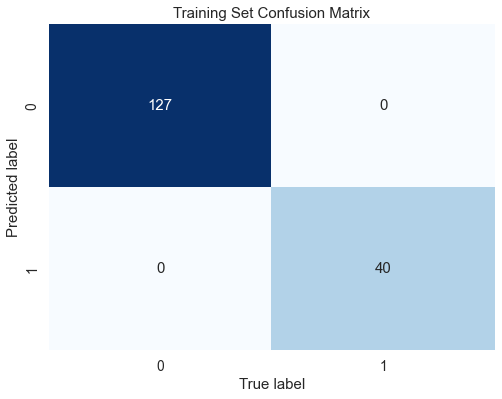

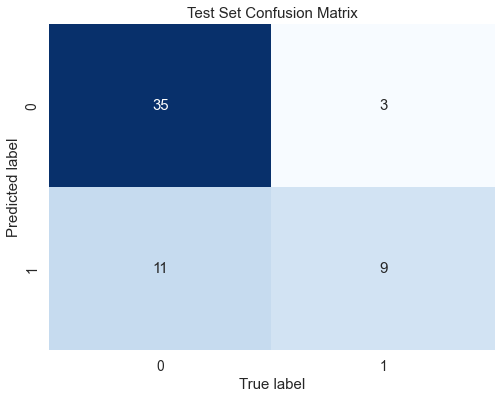

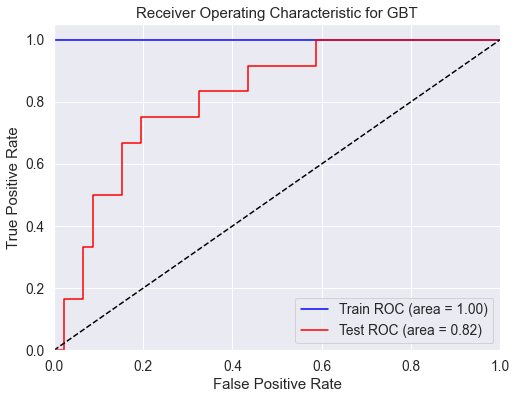

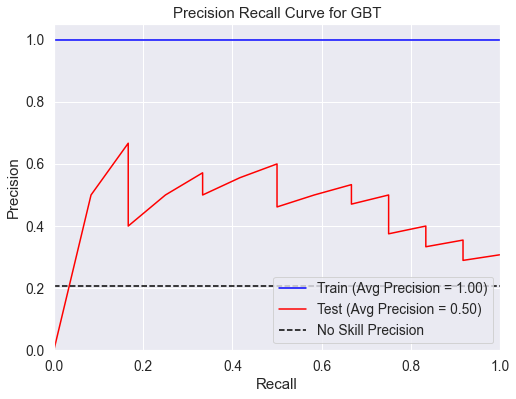

In [14]:
evaluateModel.evaluate_model(model = gbt_cv_model, 
                             model_type = "pyspark",
                             model_name = "GBT", 
                             output_path = "../output/pyspark/sample",
                             train = train, 
                             test = test)

In [15]:
spark.stop()